# **📄 Document type classification baseline code**
> 문서 타입 분류 대회에 오신 여러분 환영합니다! 🎉     
> 아래 baseline에서는 ResNet 모델을 로드하여, 모델을 학습 및 예측 파일 생성하는 프로세스에 대해 알아보겠습니다.

## Version Info
- 모델 학습 방법 : ViT
- Augmentation + 하이퍼파라미터 + 가중치 + 스케줄러 + weight decay + TTA + 홀드아웃 + 오프라인 증강

## Contents
- Prepare Environments
- Import Library & Define Functions
- Hyper-parameters
- Load Data
- Train Model
- Inference & Save File


## 1. Prepare Environments

* 데이터 로드를 위한 구글 드라이브를 마운트합니다.
* 필요한 라이브러리를 설치합니다.

In [1]:
# 구글 드라이브 마운트, Colab을 이용하지 않는다면 패스해도 됩니다.
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
drive.mount('/content/drive')

Mounted at /gdrive
Mounted at /content/drive


In [2]:
# 구글 드라이브에 업로드된 대회 데이터를 압축 해제하고 로컬에 저장합니다.
!tar -xvf drive/MyDrive/datasets_fin.tar > /dev/null

In [34]:
# 필요한 라이브러리를 설치합니다.
!pip install timm
!pip install augraphy
!pip install matplotlib
!apt-get update
!apt-get install -y libgl1-mesa-glx

Hit:1 http://security.ubuntu.com/ubuntu focal-security InRelease
Hit:2 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:3 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:4 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Reading package lists... Done
E: dpkg was interrupted, you must manually run 'dpkg --configure -a' to correct the problem. 


## 2. Import Library & Define Functions
* 학습 및 추론에 필요한 라이브러리를 로드합니다.
* 학습 및 추론에 필요한 함수와 클래스를 정의합니다.

In [111]:
import os
import time
import random

import timm
import torch
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score

os.makedirs("model", exist_ok=True)
os.makedirs("npy", exist_ok=True)
os.makedirs("submission", exist_ok=True)

In [112]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

In [113]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# data config
data_path = 'datasets_fin/'

# model config
model_name = 'convnext_base' # 'efficientnet_b1' #'resnet50' 'resnet34' # , ...

# training config - 이 부분을 수정하여 성능을 높일 수 있음 
img_size = 384
LR = 3e-5
EPOCHS = 100
BATCH_SIZE = 8
num_workers = 2 # 속도 향상을 위해 조정
N_SPLITS = 5  # 5-Fold 교차 검증
EARLY_STOPPING_PATIENCE = 10 # 5 에포크 동안 점수 향상 없으면 중단

In [64]:
import albumentations as A
from albumentations.core.transforms_interface import ImageOnlyTransform
from albumentations.pytorch import ToTensorV2

# [✅ V7 - 버그 수정] 'import *'를 사용하지 않고 'aug' 별명으로 임포트
import augraphy as aug 
from augraphy import OneOf as AugraphyOneOf 

import cv2
import random
import numpy as np
from torchvision import transforms # [✅ V6]

print("✅ [V7 - 버그 해결] 차세대 증강 함수(Augraphy, Extreme Crop, Mixup) 정의 시작...")

# [✅ V6] 1. Custom Crop 함수 정의
class QuarterDivide(ImageOnlyTransform):
    def __init__(self, always_apply=False, p=1):
        super().__init__(always_apply=always_apply, p=p)
    def apply(self, img, **params):
        height, width, _ = img.shape
        center_x, center_y = width // 2, height // 2
        results = [
            img[0:center_y, 0:center_x], img[0:center_y, center_x:width],
            img[center_y:height, 0:center_x], img[center_y:height, center_x:width]
        ]
        return results[random.randint(0, 3)]

class HalfDivide(ImageOnlyTransform):
    def __init__(self, always_apply=False, p=1):
        super().__init__(always_apply=always_apply, p=p)
    def apply(self, img, **params):
        height, width, _ = img.shape
        center_y = height // 2
        results = [img[0:center_y, :], img[center_y:height, :]]
        return results[random.randint(0, 1)]

# [✅ V6] 2. Augraphy (물리 노이즈) 파이프라인
def augraphy_transform():
    # [✅ V7 - 버그 수정] 'aug' 별명 및 'AugraphyOneOf' 별명 사용
    return aug.AugraphyPipeline(
        paper_phase = [AugraphyOneOf([aug.NoiseTexturize(p=0.5), aug.BrightnessTexturize(p=0.5)], p=0.6)],
        post_phase = [AugraphyOneOf([aug.LightingGradient(p=0.25), aug.ShadowCast(p=0.25)], p=0.25)]
    )

# [✅ V6] 3. Albumentations (기하학/잘림) 파이프라인
# (A) '종이 아님' (Non-Paper)을 위한 '가벼운' 증강
light_non_paper_augment = A.Compose([
    A.Affine(rotate=(-20, 20), shear=(-10, 10), scale=(0.9, 1.1), p=0.8),
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.8),
    A.GaussNoise(var_limit=(10.0, 30.0), p=0.5),
    A.HorizontalFlip(p=0.3),
    A.Resize(height=img_size, width=img_size, always_apply=True, p=1.0), 
])
# (B) '종이' (Paper)를 위한 '강력한 V6' 기하학(Geometric) 증강
def strong_paper_geometric_transform(img_h, img_w):
    # [✅ V7] 여기서는 'A.OneOf' (Albumentations)를 사용
    return A.Compose([
        A.Compose([
            A.LongestMaxSize(max_size=max(img_h, img_w), p=1),
            A.PadIfNeeded(min_height=img_h, min_width=img_w, border_mode=0, value=(255, 255, 255), p=1),
            A.OneOf([QuarterDivide(p=0.3), HalfDivide(p=0.3), A.RandomCrop(height=img_h//2, width=img_w//2, p=0.4)], p=0.6), 
        ], p=0.6), 
        A.OneOf([A.HorizontalFlip(p=0.3), A.VerticalFlip(p=0.3), A.Transpose(p=0.4)], p=0.6),
        A.OneOf([A.RandomRotate90(p=0.2), A.ShiftScaleRotate(rotate_limit=(-60, 60), p=0.3)], p=0.6),
        A.Resize(height=img_h, width=img_w, always_apply=True, p=1.0),
    ])

# [✅ V6 - 버그 수정] PyTorch 수동 Normalize 정의
manual_norm = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
val_transform = A.Compose([
    A.Resize(height=img_size, width=img_size),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])
tst_transform = A.Compose([
    A.Resize(height=img_size, width=img_size),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

# [✅ V6] 4. Mixup 함수 정의 (학습 루프에서 사용)
def mixup(image, targets, alpha=1.0):
    indices = torch.randperm(image.size(0))
    image_b = image[indices]
    targets_b = targets[indices]
    lam = np.random.beta(alpha, alpha)
    image_mixed = lam * image + (1 - lam) * image_b
    targets_one_hot = torch.nn.functional.one_hot(targets, num_classes=17).float()
    targets_b_one_hot = torch.nn.functional.one_hot(targets_b, num_classes=17).float()
    targets_mixed = lam * targets_one_hot + (1 - lam) * targets_b_one_hot
    return image_mixed, targets_mixed

print("✅ [V7] 차세대 증강 함수(Augraphy, Extreme Crop, Mixup) 정의 완료!")

✅ [V7 - 버그 해결] 차세대 증강 함수(Augraphy, Extreme Crop, Mixup) 정의 시작...
✅ [V7] 차세대 증강 함수(Augraphy, Extreme Crop, Mixup) 정의 완료!


In [70]:
# [✅ V6 - 버그 수정] Mixup이 적용된 'train_one_epoch'
def train_one_epoch(loader, model, optimizer, loss_fn, device):
    model.train()
    train_loss = 0
    print("===========================================")
    print(loader)
    pbar = tqdm(loader)
    
    for image, targets in pbar:
        # image는 (B, C, H, W) 0-255 텐서
        image = image.to(device)
        targets = targets.to(device)

        # --- [✅ V6 Mixup 로직] ---
        if random.random() < 0.5: # 50% 확률로 Mixup
            image_mixed, targets_mixed = mixup(image, targets, alpha=1.0)
            
            # [✅ V6 - 버그 수정] 수동 Normalize (0-1 스케일링 후)
            image_to_train = manual_norm(image_mixed / 255.0)
            targets_to_train = targets_mixed.to(device)
        else: # 50% 확률로 원본 학습
            # [✅ V6 - 버그 수정] 수동 Normalize (0-1 스케일링 후)
            image_to_train = manual_norm(image / 255.0)
            targets_to_train = torch.nn.functional.one_hot(targets, num_classes=17).float().to(device)
        # -----------------------------

        model.zero_grad(set_to_none=True)
        preds = model(image_to_train)
        
        # [✅ V6] Mixup 라벨(float)과 예측(logit)의 Loss 계산
        loss = -torch.mean(torch.sum(targets_to_train * torch.log_softmax(preds, dim=1), dim=1))
        
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        pbar.set_description(f"Loss: {loss.item():.4f}")

    train_loss /= len(loader)
    ret = {"train_loss": train_loss, "train_acc": 0, "train_f1": 0}
    return ret

## 3. Hyper-parameters
* 학습 및 추론에 필요한 하이퍼파라미터들을 정의합니다.

## 4. Load Data
* 학습, 테스트 데이터셋과 로더를 정의합니다.

In [66]:
# 원본 CSV 불러오기
all_df = pd.read_csv("datasets_fin/train.csv")

# [✅ 핵심] 1570개를 8:2 비율로 '학습용'과 '미니 리더보드용'으로 분리
# stratify=all_df['target'] : 17개 클래스 비율을 유지하며 섞어줌 (Macro F1 문제 해결!)
train_df, holdout_df = train_test_split(
    all_df, 
    test_size=0.2,    # 20%를 미니 리더보드(holdout)로 사용
    random_state=42,  # 항상 동일하게 분리
    stratify=all_df['target'] 
)

# 학습은 80% 데이터로만 진행 (1570 * 0.8 = 약 1256개)
df = train_df.reset_index(drop=True) 

print(f"총 데이터: {len(all_df)}, 학습용: {len(df)}, 미니 리더보드용: {len(holdout_df)}")

총 데이터: 1570, 학습용: 1256, 미니 리더보드용: 314


In [67]:
# Validation 함수
def validate_one_epoch(loader, model, loss_fn, device):
    model.eval() # 모델을 평가 모드로 설정
    val_loss = 0
    preds_list = []
    targets_list = []

    with torch.no_grad(): # 기울기 계산 비활성화
        pbar = tqdm(loader, desc="Valid")
        for image, targets in pbar:
            image = image.to(device)
            targets = targets.to(device)
            
            preds = model(image)
            loss = loss_fn(preds, targets)

            val_loss += loss.item()
            preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
            targets_list.extend(targets.detach().cpu().numpy())
            pbar.set_description(f"Valid Loss: {loss.item():.4f}")

    val_loss /= len(loader)
    val_acc = accuracy_score(targets_list, preds_list)
    val_f1 = f1_score(targets_list, preds_list, average='macro') # Macro F1

    ret = {
        "val_loss": val_loss,
        "val_acc": val_acc,
        "val_f1": val_f1,
    }
    return ret

In [ ]:
from PIL import Image

# [✅ V6 - 수정됨] '차세대 증강' 조건부 ImageDataset
class ImageDataset(Dataset):
    
    # [✅ 사용자님 분류 기준] (이전에 사용한 V5 리스트)
    PAPER_TARGETS = {1, 3, 4, 6, 7, 11, 12, 14, 15, 0, 10, 13} # '종이' 리스트

    def __init__(self, df, path, 
                 mode='train', # 'train', 'val', 'test' 모드
                 img_size=img_size, 
                 target_col='target'):
        
        self.df = df 
        self.path = path
        self.target_col = target_col
        self.mode = mode
        self.img_size = img_size

        # --- [V6] 파이프라인을 __init__에서 한 번만 생성! ---
        if mode == 'train':
            self.augraphy_pipe = augraphy_transform()
            self.strong_geometric_pipe = strong_paper_geometric_transform(img_size, img_size)
            self.mild_pipe = light_non_paper_augment
            # (Normalize는 Cell 8에서 수동 처리)
        else:
            self.val_pipe = val_transform # (Cell 8에서 정의됨)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name = self.df.iloc[idx]['ID']
        target = self.df.iloc[idx][self.target_col]
        
        img_path = os.path.join(self.path, name)
        try:
            image = np.array(Image.open(img_path).convert("RGB"))
        except Exception as e:
            print(f"Error opening image {img_path}: {e}")
            return torch.randn(3, self.img_size, self.img_size), 0
            
        # --- [✅ V6 핵심 로직] ---
        if self.mode == 'train':
            if target in self.PAPER_TARGETS:
                image = self.augraphy_pipe(image=image)['image']
                image = self.strong_geometric_pipe(image=image)['image']
            else:
                image = self.mild_pipe(image=image)['image']
            
            # [✅ V6] 0-255 텐서로 변환 (Normalize는 Cell 8에서)
            img = torch.from_numpy(image.transpose((2, 0, 1))).float() # (H, W, C) -> (C, H, W)
                
        else: # 'val' 또는 'test' 모드
            img = self.val_pipe(image=image)['image'] # val_pipe는 Normalize/ToTensorV2 포함
            
        return img, target

## 5. Train Model
* 모델을 로드하고, 학습을 진행합니다.

In [73]:
# [✅ V6 - 수정됨] ImageDataset 생성 (온라인 방식)

# 1. 학습 데이터 = 1256개 원본 (df)
# (V6는 '온라인' 증강이므로, 6280개가 아닌 1256개 원본(df)을 사용!)
print(f"학습용 원본 데이터(df) 로드 중... (총 {len(df)}개)")
trn_dataset = ImageDataset(
    df,                       # [✅ V6] aug_df -> df (1256개)
    "datasets_fin/train/",    # [✅ V6] train_aug -> train (원본 폴더)
    mode='train',             # [✅ V6] 'train' 모드
    img_size=img_size,        # [✅ V6] img_size 전달
    target_col='target'
)

# 2. 검증 데이터 = 314개 깨끗한 홀드아웃 (holdout_df)
print(f"검증용 홀드아웃(holdout_df) 로드 중... (총 {len(holdout_df)}개)")
val_dataset = ImageDataset(
    holdout_df,               
    "datasets_fin/train/",    
    mode='val',               # [✅ V6] 'val' 모드
    img_size=img_size,        # [✅ V6] img_size 전달
    target_col='target'
)

# DataLoader 정의
trn_loader = DataLoader(
    trn_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    drop_last=False
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

# load model
model = timm.create_model(
    model_name,
    pretrained=True,
    num_classes=17
).to(device)

# [✅ V6] Loss 함수 수정 (검증용)
loss_fn = nn.CrossEntropyLoss() # (Mixup은 Cell 8에서 수동 계산)

# [✅ V6] Optimizer 수정 (ConvNeXt/ViT/Swin은 AdamW 추천)
from torch.optim import AdamW
optimizer = AdamW(model.parameters(), 
                  lr=LR, # (LR=3e-5 (ConvNeXt/ViT) 또는 1e-4 (B4))
                  weight_decay=1e-2 # (AdamW는 1e-2 또는 1e-4)
                 )
# (만약 Adam을 고수한다면 optimizer = Adam(model.parameters(), lr=LR, weight_decay=1e-4))

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

# Early Stopping을 위한 변수
best_val_f1 = 0.0
patience_counter = 0

print(f"--- '미니 리더보드' 학습 시작 (V6 Augraphy + Mixup) ---")
print(f"학습 데이터: {len(trn_dataset)}개 (온라인 V6 증강)")
print(f"검증 데이터: {len(val_dataset)}개 (깨끗한 원본)")

for epoch in range(EPOCHS):
    start_time = time.time()

    # [✅ V6] Cell 8에서 정의된 V6 학습 루프 호출
    train_ret = train_one_epoch(trn_loader, model, optimizer, loss_fn, device=device)
    
    val_ret = validate_one_epoch(val_loader, model, loss_fn, device)
    
    elapsed = time.time() - start_time
    scheduler.step()
    
    print(f"Epoch {epoch+1}/{EPOCHS} [{elapsed:.0f}s] - "
          f"Train F1: {train_ret['train_f1']:.4f}, " # (V6는 0으로 표시됨)
          f"Valid F1 (Holdout): {val_ret['val_f1']:.4f}, " # <- 이게 진짜 점수
          f"Valid Loss: {val_ret['val_loss']:.4f}")

    # Early Stopping 및 모델 저장 로직
    if val_ret['val_f1'] > best_val_f1:
        best_val_f1 = val_ret['val_f1']
        torch.save(model.state_dict(), f"model/best_conv_model_V6.pth") 
        print(f"⭐️ Best F1 Score updated to {best_val_f1:.4f}. Model saved!")
        patience_counter = 0 
    else:
        patience_counter += 1
    
    if patience_counter >= EARLY_STOPPING_PATIENCE:
        print(f"Early stopping at epoch {epoch+1} as F1 score did not improve for {EARLY_STOPPING_PATIENCE} epochs.")
        break

print(f"--- V6 학습 완료 ---")
print(f"최종 '미니 리더보드' F1 점수: {best_val_f1:.4f}")

학습용 원본 데이터(df) 로드 중... (총 1256개)
검증용 홀드아웃(holdout_df) 로드 중... (총 314개)
--- '미니 리더보드' 학습 시작 (V6 Augraphy + Mixup) ---
학습 데이터: 1256개 (온라인 V6 증강)
검증 데이터: 314개 (깨끗한 원본)


Valid Loss: 0.9130: 100%|██████████| 40/40 [00:06<00:00,  6.40it/s]


Epoch 1/100 [45s] - Train F1: 0.0000, Valid F1 (Holdout): 0.7668, Valid Loss: 0.6489
⭐️ Best F1 Score updated to 0.7668. Model saved!


Valid Loss: 0.7266: 100%|██████████| 40/40 [00:01<00:00, 38.52it/s]


Epoch 2/100 [31s] - Train F1: 0.0000, Valid F1 (Holdout): 0.8471, Valid Loss: 0.4122
⭐️ Best F1 Score updated to 0.8471. Model saved!


Valid Loss: 0.9173: 100%|██████████| 40/40 [00:01<00:00, 39.10it/s]


Epoch 3/100 [34s] - Train F1: 0.0000, Valid F1 (Holdout): 0.8523, Valid Loss: 0.3282
⭐️ Best F1 Score updated to 0.8523. Model saved!


Valid Loss: 0.4596: 100%|██████████| 40/40 [00:01<00:00, 39.14it/s]


Epoch 4/100 [34s] - Train F1: 0.0000, Valid F1 (Holdout): 0.8799, Valid Loss: 0.2922
⭐️ Best F1 Score updated to 0.8799. Model saved!


Valid Loss: 0.4344: 100%|██████████| 40/40 [00:01<00:00, 38.53it/s]


Epoch 5/100 [33s] - Train F1: 0.0000, Valid F1 (Holdout): 0.8740, Valid Loss: 0.2492


Valid Loss: 0.6200: 100%|██████████| 40/40 [00:01<00:00, 38.05it/s]


Epoch 6/100 [33s] - Train F1: 0.0000, Valid F1 (Holdout): 0.8735, Valid Loss: 0.3006


Valid Loss: 0.2129: 100%|██████████| 40/40 [00:01<00:00, 38.86it/s]


Epoch 7/100 [33s] - Train F1: 0.0000, Valid F1 (Holdout): 0.9016, Valid Loss: 0.2242
⭐️ Best F1 Score updated to 0.9016. Model saved!


Valid Loss: 0.2424: 100%|██████████| 40/40 [00:01<00:00, 39.09it/s]


Epoch 8/100 [33s] - Train F1: 0.0000, Valid F1 (Holdout): 0.9169, Valid Loss: 0.2132
⭐️ Best F1 Score updated to 0.9169. Model saved!


Valid Loss: 0.4205: 100%|██████████| 40/40 [00:01<00:00, 39.08it/s]


Epoch 9/100 [31s] - Train F1: 0.0000, Valid F1 (Holdout): 0.8990, Valid Loss: 0.2237


Valid Loss: 0.0809: 100%|██████████| 40/40 [00:01<00:00, 38.56it/s]


Epoch 10/100 [33s] - Train F1: 0.0000, Valid F1 (Holdout): 0.9240, Valid Loss: 0.1996
⭐️ Best F1 Score updated to 0.9240. Model saved!


Valid Loss: 0.1494: 100%|██████████| 40/40 [00:01<00:00, 39.08it/s]


Epoch 11/100 [32s] - Train F1: 0.0000, Valid F1 (Holdout): 0.8749, Valid Loss: 0.2712


Valid Loss: 0.4569: 100%|██████████| 40/40 [00:01<00:00, 38.78it/s]


Epoch 12/100 [33s] - Train F1: 0.0000, Valid F1 (Holdout): 0.8961, Valid Loss: 0.2210


Valid Loss: 0.0536: 100%|██████████| 40/40 [00:01<00:00, 38.60it/s]


Epoch 13/100 [32s] - Train F1: 0.0000, Valid F1 (Holdout): 0.8946, Valid Loss: 0.2457


Valid Loss: 0.2346: 100%|██████████| 40/40 [00:01<00:00, 38.69it/s]


Epoch 14/100 [33s] - Train F1: 0.0000, Valid F1 (Holdout): 0.9147, Valid Loss: 0.1762


Valid Loss: 0.2473: 100%|██████████| 40/40 [00:01<00:00, 39.03it/s]


Epoch 15/100 [34s] - Train F1: 0.0000, Valid F1 (Holdout): 0.9302, Valid Loss: 0.1760
⭐️ Best F1 Score updated to 0.9302. Model saved!


Valid Loss: 0.2563: 100%|██████████| 40/40 [00:01<00:00, 38.30it/s]


Epoch 16/100 [33s] - Train F1: 0.0000, Valid F1 (Holdout): 0.9210, Valid Loss: 0.1830


Valid Loss: 0.2300: 100%|██████████| 40/40 [00:01<00:00, 38.82it/s]


Epoch 17/100 [34s] - Train F1: 0.0000, Valid F1 (Holdout): 0.9034, Valid Loss: 0.2098


Valid Loss: 0.5013: 100%|██████████| 40/40 [00:01<00:00, 39.00it/s]


Epoch 18/100 [31s] - Train F1: 0.0000, Valid F1 (Holdout): 0.9076, Valid Loss: 0.2195


Loss: 0.1889:   1%|          | 1/157 [00:00<00:55,  2.80it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73f95efc70>
Traceback (most recent call last):
  File "/workspace/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/workspace/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73f95efc70>
Traceback (most recent call last):
  File "/workspace/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/workspace/.venv/lib/python3.10/site-packages/torch/utils/

Epoch 19/100 [33s] - Train F1: 0.0000, Valid F1 (Holdout): 0.9125, Valid Loss: 0.1868


  0%|          | 0/157 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73f95efc70>
Traceback (most recent call last):
  File "/workspace/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/workspace/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
Exception ignored in:     if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x7f73f95efc70>

  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
Traceback (most recent call last):
      File "/workspace/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
assert self._parent_pid == os.getpid(), 'can only test a child process'    
self._shutdown_workers()AssertionError
:   File "/workspace/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers

Epoch 20/100 [34s] - Train F1: 0.0000, Valid F1 (Holdout): 0.9192, Valid Loss: 0.1831


Loss: 0.0983:   1%|          | 1/157 [00:00<01:03,  2.47it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73f95efc70>
Traceback (most recent call last):
  File "/workspace/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/workspace/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73f95efc70>
Traceback (most recent call last):
  File "/workspace/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/workspace/.venv/lib/python3.10/site-packages/torch/utils/

Epoch 21/100 [31s] - Train F1: 0.0000, Valid F1 (Holdout): 0.9181, Valid Loss: 0.2182


  0%|          | 0/157 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73f95efc70>
Traceback (most recent call last):
  File "/workspace/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/workspace/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73f95efc70>
Traceback (most recent call last):
  File "/workspace/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/workspace/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", l

Epoch 22/100 [30s] - Train F1: 0.0000, Valid F1 (Holdout): 0.9166, Valid Loss: 0.1827


  0%|          | 0/157 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73f95efc70>
Traceback (most recent call last):
  File "/workspace/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/workspace/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73f95efc70>
Traceback (most recent call last):
  File "/workspace/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/workspace/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", l

Epoch 23/100 [36s] - Train F1: 0.0000, Valid F1 (Holdout): 0.9551, Valid Loss: 0.1535
⭐️ Best F1 Score updated to 0.9551. Model saved!


Loss: 0.0229:   1%|          | 1/157 [00:00<00:58,  2.66it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73f95efc70>
Traceback (most recent call last):
  File "/workspace/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/workspace/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73f95efc70>
Traceback (most recent call last):
  File "/workspace/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/workspace/.venv/lib/python3.10/site-packages/torch/utils/

Epoch 24/100 [34s] - Train F1: 0.0000, Valid F1 (Holdout): 0.9114, Valid Loss: 0.2257


  0%|          | 0/157 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73f95efc70>
Traceback (most recent call last):
  File "/workspace/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/workspace/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73f95efc70>
Traceback (most recent call last):
  File "/workspace/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/workspace/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", l

Epoch 25/100 [34s] - Train F1: 0.0000, Valid F1 (Holdout): 0.9498, Valid Loss: 0.1498


  0%|          | 0/157 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73f95efc70>
Traceback (most recent call last):
  File "/workspace/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/workspace/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73f95efc70>
Traceback (most recent call last):
  File "/workspace/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/workspace/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", l

Epoch 26/100 [34s] - Train F1: 0.0000, Valid F1 (Holdout): 0.9200, Valid Loss: 0.1973


Loss: 1.4196:   1%|          | 1/157 [00:00<01:02,  2.50it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73f95efc70>
Traceback (most recent call last):
  File "/workspace/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/workspace/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73f95efc70>
Traceback (most recent call last):
  File "/workspace/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/workspace/.venv/lib/python3.10/site-packages/torch/utils/

Epoch 27/100 [36s] - Train F1: 0.0000, Valid F1 (Holdout): 0.9370, Valid Loss: 0.1681


  0%|          | 0/157 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73f95efc70>
Traceback (most recent call last):
  File "/workspace/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/workspace/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73f95efc70>
Traceback (most recent call last):
  File "/workspace/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/workspace/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", l

Epoch 28/100 [33s] - Train F1: 0.0000, Valid F1 (Holdout): 0.9484, Valid Loss: 0.1623


  0%|          | 0/157 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73f95efc70>
Traceback (most recent call last):
  File "/workspace/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/workspace/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73f95efc70>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f73f95efc70>Traceback (most recent call last):

  File "/workspace/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Traceback (most recent call

Epoch 29/100 [36s] - Train F1: 0.0000, Valid F1 (Holdout): 0.9287, Valid Loss: 0.2222


Valid Loss: 0.1570: 100%|██████████| 40/40 [00:01<00:00, 38.24it/s]


Epoch 30/100 [35s] - Train F1: 0.0000, Valid F1 (Holdout): 0.9254, Valid Loss: 0.1842


Valid Loss: 0.0307: 100%|██████████| 40/40 [00:01<00:00, 38.61it/s]


Epoch 31/100 [33s] - Train F1: 0.0000, Valid F1 (Holdout): 0.9420, Valid Loss: 0.1545


Valid Loss: 0.4847: 100%|██████████| 40/40 [00:01<00:00, 38.46it/s]


Epoch 32/100 [36s] - Train F1: 0.0000, Valid F1 (Holdout): 0.9138, Valid Loss: 0.2184


Valid Loss: 0.4879: 100%|██████████| 40/40 [00:01<00:00, 38.54it/s]

Epoch 33/100 [35s] - Train F1: 0.0000, Valid F1 (Holdout): 0.9090, Valid Loss: 0.2591
Early stopping at epoch 33 as F1 score did not improve for 10 epochs.
--- V6 학습 완료 ---
최종 '미니 리더보드' F1 점수: 0.9551


# 6. Inference & Save File
* 테스트 이미지에 대한 추론을 진행하고, 결과 파일을 저장합니다.

In [92]:
import numpy as np
import pandas as pd
import torch
import timm
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm

# --- TTA 적용 '미니 리더보드' 점수 계산 시작 ---
print("--- TTA 적용 '미니 리더보드' 점수 계산 시작 ---")

# (주의: Cell 54에서 생성된 'holdout_df' 변수가 살아있어야 합니다)
if 'holdout_df' not in globals():
    print("오류: 'holdout_df'가 없습니다. Load Data 섹터를 다시 실행해야 할 수 있습니다.")
else:
    print(f"홀드아웃 데이터(holdout_df) 로드 중... (총 {len(holdout_df)}개)")

    # 1. TTA용 데이터로더 생성
    # [✅ 핵심] 'transform=tst_transform'을 사용합니다!
    holdout_tta_dataset = ImageDataset(
        holdout_df,               
        "datasets_fin/train/",    
        mode='val',               # [✅ V6] 'val' 모드
        img_size=img_size,        # [✅ V6] img_size 전달
        target_col='target'
    )

    holdout_tta_loader = DataLoader(
        holdout_tta_dataset,
        batch_size=BATCH_SIZE * 2, # 추론은 배치 2배로
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    # 2. 저장된 베스트 모델 불러오기
    model = timm.create_model(model_name, pretrained=False, num_classes=17).to(device)
    model_path = "model/best_conv_model_V6.pth" # 학습에서 저장된 경로
    model.load_state_dict(torch.load(model_path))
    model.eval()
    print(f"모델 {model_path} 로드 완료.")

    # 3. TTA 추론 실행 (Inference 섹션 코드 재활용)
    tta_preds_list = []
    with torch.no_grad():
        for image, _ in tqdm(holdout_tta_loader, desc="TTA 추론 중"):
            image = image.to(device)
            
            # TTA 0: 원본 예측
            pred_orig = model(image)

            # TTA 1: 좌우 반전
            image_hflip = torch.flip(image, dims=[-1]) 
            pred_hflip = model(image_hflip)
            
            # TTA 2: 90도 회전
            image_rot90 = torch.rot90(image, k=1, dims=[-2, -1])
            pred_rot90 = model(image_rot90)

            # 3개 예측의 확률(softmax)을 평균냄
            avg_batch_pred = (pred_orig.softmax(dim=1) + 
                              pred_hflip.softmax(dim=1) + 
                              pred_rot90.softmax(dim=1)) / 3.0
            
            tta_preds_list.append(avg_batch_pred.cpu().numpy())
    
    # (314, 17) 크기의 배열로 합치기
    final_tta_preds_array = np.concatenate(tta_preds_list, axis=0)

    # 4. TTA 적용 점수 계산
    # 최종 예측 라벨 (가장 확률 높은 것)
    final_tta_labels = np.argmax(final_tta_preds_array, axis=1)
    
    # 실제 정답 라벨
    true_labels = holdout_df['target'].values
    
    # Macro F1 스코어 계산
    tta_f1_score = f1_score(true_labels, final_tta_labels, average='macro')
    tta_acc_score = accuracy_score(true_labels, final_tta_labels)

    print("\n--- TTA 적용 '미니 리더보드' 최종 점수 ---")
    print(f"✅ TTA 적용 Macro F1: {tta_f1_score:.4f}")
    print(f"   (TTA 적용 Accuracy: {tta_acc_score:.4f})")
    
    # 홀드아웃 예측 확률 저장
    np.save("npy/conv_holdout_preds.npy", final_tta_preds_array)

--- TTA 적용 '미니 리더보드' 점수 계산 시작 ---
홀드아웃 데이터(holdout_df) 로드 중... (총 314개)
모델 model/best_conv_model_V6.pth 로드 완료.


TTA 추론 중: 100%|██████████| 20/20 [00:02<00:00,  7.57it/s]


--- TTA 적용 '미니 리더보드' 최종 점수 ---
✅ TTA 적용 Macro F1: 0.9597
   (TTA 적용 Accuracy: 0.9618)


In [94]:
tst_df = pd.read_csv("datasets_fin/sample_submission.csv")
# tst_dataset = ImageDataset(
#     tst_df,
#     "datasets_fin/test/",
#     transform=tst_transform  # Test 셋에는 증강이 없는 val_transform 사용
# )

tst_dataset = ImageDataset(
    tst_df,               
    "datasets_fin/test/",    
    mode='val',               # [✅ V6] 'val' 모드
)

tst_loader = DataLoader(
    tst_dataset,
    batch_size=BATCH_SIZE * 2,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

# 2. 저장된 베스트 모델 불러오기
model = timm.create_model(model_name, pretrained=False, num_classes=17).to(device)
model_path = "model/best_conv_model_V6.pth" # 학습에서 저장된 경로
model.load_state_dict(torch.load(model_path))
model.eval()
print(f"모델 {model_path} 로드 완료.")

# 3. TTA 추론 실행 (Inference 섹션 코드 재활용)
tta_preds_list = []
with torch.no_grad():
    for image, _ in tqdm(tst_loader, desc="TTA 추론 중"):
        image = image.to(device)
        
        # TTA 0: 원본 예측
        pred_orig = model(image)

        # TTA 1: 좌우 반전
        image_hflip = torch.flip(image, dims=[-1]) 
        pred_hflip = model(image_hflip)
        
        # TTA 2: 90도 회전
        image_rot90 = torch.rot90(image, k=1, dims=[-2, -1])
        pred_rot90 = model(image_rot90)

        # 3개 예측의 확률(softmax)을 평균냄
        avg_batch_pred = (pred_orig.softmax(dim=1) + 
                            pred_hflip.softmax(dim=1) + 
                            pred_rot90.softmax(dim=1)) / 3.0
        
        tta_preds_list.append(avg_batch_pred.cpu().numpy())

# 4. 최종 예측 라벨 생성
final_tta_preds_array = np.concatenate(tta_preds_list, axis=0)

np.save("npy/conv_final_preds.npy", final_tta_preds_array) 
print("ConvNeXt 평균 확률 저장 완료!")

final_tta_labels = np.argmax(final_tta_preds_array, axis=1)

# 5. [✅ 수정됨] F1 스코어 계산 부분 ***완전 삭제***
# (우리는 '진짜 테스트 데이터'의 정답을 모르므로 계산 불가능)
print("추론 완료. 제출 파일 생성 중...")

# 6. [✅ 수정됨] 제출 파일 생성
pred_df = tst_df.copy()
# [중요!] '가짜 정답'(true_labels)이 아닌, '모델의 예측'(final_tta_labels)을 넣어야 함
pred_df['target'] = final_tta_labels

모델 model/best_conv_model_V6.pth 로드 완료.


TTA 추론 중: 100%|██████████| 197/197 [00:30<00:00,  6.51it/s]

ConvNeXt 평균 확률 저장 완료!
추론 완료. 제출 파일 생성 중...


In [20]:
print(final_tta_labels)

[ 2 12  5 ...  8  0 12]


In [95]:
assert (tst_df['ID'] == pred_df['ID']).all()

In [96]:
pred_df.to_csv("submission/pred14.csv", index=False)
print("Submission file created!")

Submission file created!


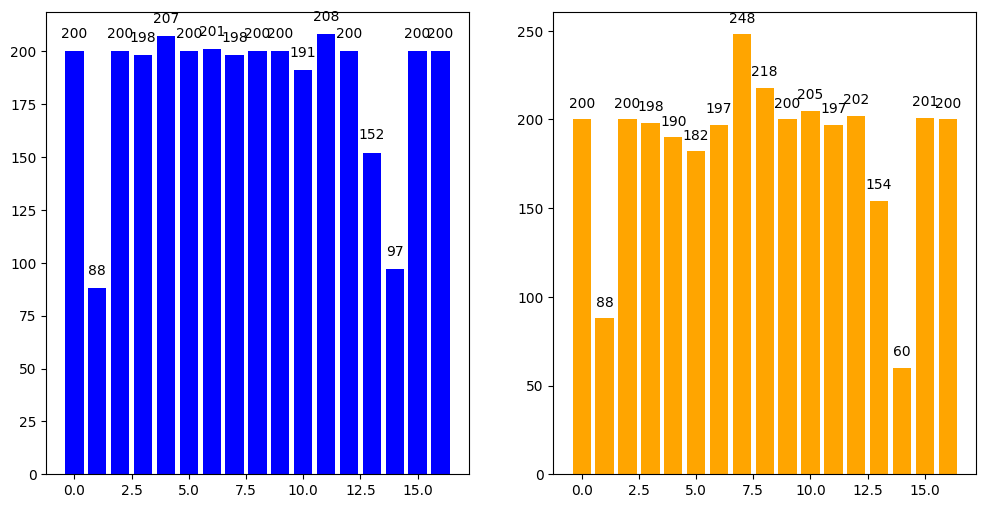

In [114]:
import os
import pandas as pd

# submission.csv 로드
submission_df = pd.read_csv("datasets_fin/submission.csv")

# minseo.csv 로드
minseo_df = pd.read_csv("submission/pred14.csv")

# 두 df의 target 분포 시각화 bar plot 비교, bar 상단에 갯수 표시
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
submission_counts = submission_df['target'].value_counts().sort_index()
bars = plt.bar(submission_counts.index, submission_counts.values, color='blue')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, int(yval), ha='center', va='bottom')
plt.subplot(1, 2, 2)
minseo_counts = minseo_df['target'].value_counts().sort_index()
bars = plt.bar(minseo_counts.index, minseo_counts.values, color='orange')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, int(yval), ha='center', va='bottom')
plt.show()

